# Описательная статистика

## Датасет

Ссылка |
-- |
https://www.kaggle.com/nikdavis/steam-store-games |

Столбец | Описание
-- | --
appid | ИД
name | Название
release_date | Дата релиза
developer | Разработчики
publisher | Издатели
platforms | Платформы
categories | Категории
genres | Жанры
positive_ratings | Кол-во положительных рейтингов
negative_ratings | Кол-во отрицательных рейтингов
average_playtime | Среднее время в игре
median_playtime | Срединное время в игре
owners | Кол-во продаж
price | Цена (в фунтах стерлингов)

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Нам пригодятся два датасета. Объединим их в один по столбцу "appid".

In [14]:
df = pd.read_csv('data/steam.csv')

In [3]:
df.drop(columns=['english', 'required_age', 'achievements', 'appid', 'name'], inplace=True)
df.sample(2)

,release_date,developer,publisher,platforms,categories,genres,steamspy_tags,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
25350,2019-01-15,Microsoft Corporation,Microsoft Corporation,windows,Single-player,Casual;Free to Play,VR;Design & Illustration;Beautiful,21,1,8,8,20000-50000,0.00
15025,2019-02-26,Andrew Higgins,Andrew Higgins,windows,Single-player;Steam Achievements;Full controll...,Indie;RPG,RPG;Indie,9,3,0,0,0-20000,3.99


In [4]:
# Напишем сплющивающую функцию для работы с многозначными полями в датафрейме, вскоре нам это пригодится.

import collections
import itertools


def flatten(column):
    _temp = [p.split(';') for p in column]
    return list(itertools.chain.from_iterable(_temp))

In [5]:
flatten(df.categories[:3])

['Multi-player',
 'Online Multi-Player',
 'Local Multi-Player',
 'Valve Anti-Cheat enabled',
 'Multi-player',
 'Online Multi-Player',
 'Local Multi-Player',
 'Valve Anti-Cheat enabled',
 'Multi-player',
 'Valve Anti-Cheat enabled']

In [15]:
# Вынесем год издания игры в отдельный столбец для удобства
df['release_year'] = pd.DatetimeIndex(df['release_date']).year

In [7]:
df.sample(2)

,release_date,developer,publisher,platforms,categories,genres,steamspy_tags,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,release_year
25233,2018-11-23,Playloft,Playloft,windows;mac,Single-player;Steam Achievements,Indie;Simulation,Indie;Simulation;Racing,0,1,0,0,0-20000,4.79,2018
15813,2017-08-02,Lord of the Stack,Lord of the Stack,windows,Single-player;Steam Achievements;Steam Leaderb...,Violent;Action;Casual;Indie;Sports,Action;Indie;Casual,32,4,0,0,0-20000,1.69,2017


In [16]:
# Чтобы как-то осмысленно поработать с количеством пользователей,
# возьмем верхнюю границу интервала, который приведен в датасете.

df.owners = df.owners.str.replace('\d+-', '')
df.owners = pd.to_numeric(df.owners)

In [9]:
df.corr()

,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,release_year
positive_ratings,1.000000,0.762804,0.157898,0.035776,0.712447,0.036110,-0.064384
negative_ratings,0.762804,1.000000,0.161140,0.047887,0.686658,0.051259,-0.034860
average_playtime,0.157898,0.161140,1.000000,0.914900,0.174142,0.049242,-0.052997
median_playtime,0.035776,0.047887,0.914900,1.000000,0.035965,0.036610,-0.034508
owners,0.712447,0.686658,0.174142,0.035965,1.000000,0.031386,-0.143610
price,0.036110,0.051259,0.049242,0.036610,0.031386,1.000000,-0.057292
release_year,-0.064384,-0.034860,-0.052997,-0.034508,-0.143610,-0.057292,1.000000


In [ ]:
# Возьмем проработанный датафрейм и соединим с дополнительными данными о тэгах со SteamSpy 
# в другом файле и сохраним для графиков для следующей лабораторной.

_tag_data = pd.read_csv('data/steamspy_tag_data.csv')
_df = pd.merge(left=df, right=_tag_data, how='inner', on='appid')  # Было использовано до удаления столбца appid.
_df.to_csv('processed.csv')

## Проверяем гипотезы

### Количество игр на площадке растет экспоненциально

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 <a list of 22 Text xticklabel objects>)

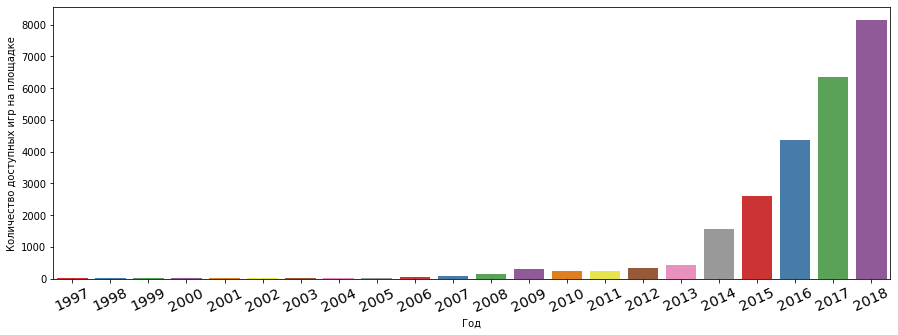

In [10]:
plt.figure(figsize=(15,5))

ax = sns.barplot(
    x=sorted(set(df.release_year))[:-1],
    y=df.groupby('release_year').count().owners[:-1],
    palette='Set1'
)

ax.set(xlabel='Год', ylabel='Количество доступных игр на площадке')
plt.xticks(rotation=25, horizontalalignment='center', fontweight='light', fontsize='x-large')

Похоже, что мы были правы! Замечание: выкинули последний год, потому что сам датасет собирался в начале 2019.

### Windows –– самая популярная игровая платформа

(-1.1032014263468737,
 1.1001524756038639,
 -1.119790740514518,
 1.1025829889714132)

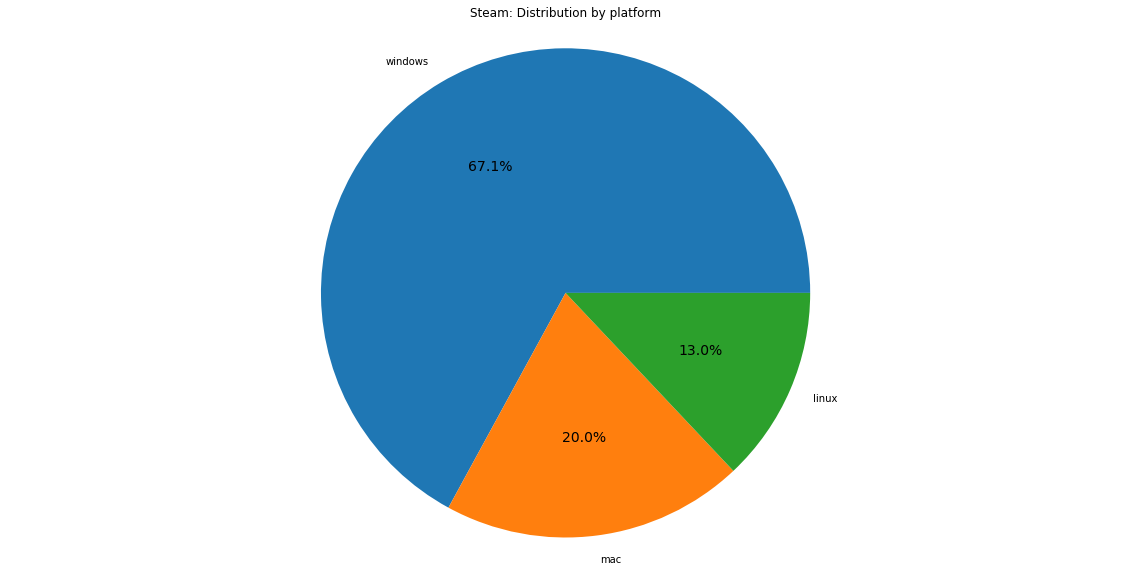

In [11]:
_platforms = collections.Counter(flatten(df.platforms))

labels = _platforms.keys()
values = _platforms.values()

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))

_, _, autotexts = plt.pie(values, labels=labels, autopct='%1.1f%%')

plt.setp(autotexts, size=14, weight='light')

ax.set_title("Steam: Distribution by platform")

plt.axis('equal')

Действительно, большинство игр выпускается под Windows.

### Инди –– самый распространенный жанр на площадке

(-1.1103141330480817,
 1.17938500513346,
 -1.1044951315147813,
 1.1596563448362072)

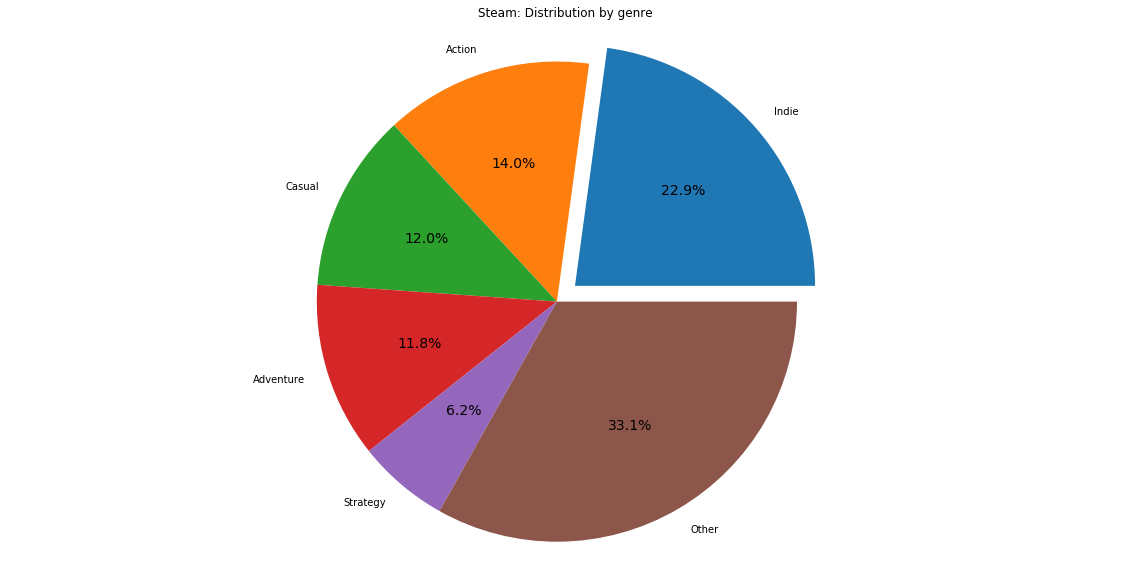

In [12]:
_genres = collections.Counter(flatten(df.genres))

# Отберем топ-5 жанров.
_top_genres = _genres.most_common(5)

# Остальные сгруппируем и добавим как "Other".
labels = [name for name, _ in _top_genres] + ['Other']
values = [count for _, count in _top_genres] + [sum(list(_genres.values())[5:])]

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = plt.pie(values, labels=labels, 
                                   autopct='%1.1f%%', explode=[0.1] + [0 for _ in range(len(values) - 1)])

plt.setp(autotexts, size=14, weight="light")

ax.set_title("Steam: Distribution by genre")

plt.axis('equal')

Итак, больше всего игр на площадке от **независимых разработчиков (больше 20\%)**, что неудивительно, учитывая что взнос за публикацию игры составляет всего $100 при таких масштабах аудитории, как в Steam. Затем следуют игры в жанрах **Экшн (14\%)**, **Казуальная и Приключенческая (12\%)**, и **Стратегия (6\%)**. **Оставшаяся треть** жанров состоит из категорий, по отдельности составляющих менее 5\% от всех жанров, так что мы их не покажем.